In [3]:
import pandas as pd
import numpy as np
#import pandas_profiling 
#import seaborn as sns
import matplotlib.pyplot as plt
#from string import ascii_letters
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix,accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#from sklearn.cluster import DBSCAN
#from sklearn.decomposition import PCA
import unidecode as uni
import time
import pickle
pd.set_option('display.max_columns', None)

def Outliers(p_data, Desviacion):
    data_modificada = p_data
    
    # GENERO CULUMNA DE MEDIAS AGRUPANDO
    media__ = data_modificada.groupby(['RuntimeMinutes','Action','Adventure','Animation','apropiado','fecha_anio'])['Budget'].transform('mean')
    #GENERO COLUMNA DE STD AGRUPANDO
    str__ = data_modificada.groupby(['RuntimeMinutes','Action','Adventure','Animation','apropiado','fecha_anio'])['Budget'].transform('std')
    #GENERO COLUMNA CON LA FORMULA DE CHEUVENET PARA EL CALCULO DE OUTLIERS
    criterio_cheuvenet__ = (abs(data_modificada.Budget-media__))/(str__)

    data_modificada.Budget.loc[criterio_cheuvenet__>Desviacion] = np.nan
    return data_modificada 

## ARMO DATASETS DE PELICULAS 

In [4]:
data = pd.read_csv('data_movies_final.csv',sep='|').iloc[:,1:]
data['Rate'][data.Rate>10] = data.Rate[data.Rate>10]*0.10
data['fecha_mes'] = data['fecha'][data.fecha.notnull()]
dummies_meses = pd.get_dummies(data.fecha_mes[data.fecha_mes.notnull()].str.split(pat='-').apply(lambda x: x[1])).rename(columns={'01':'ENERO','02':'FEBRERO','03':'MARZO','04':'ABRIL','05':'MAYO','06':'JUNIO','07':'JULIO','08':'AGOSTO','09':'SEPTIEMBRE','10':'OCTUBRE','11':'NOVIEMBRE','12':'DICIEMBRE'})
data = pd.concat([data,dummies_meses],axis=1)
data = data[data.fecha_mes.notnull()]
data = data.drop(['IDDataLens','cant_baja_votos','cant_media_votos','cant_alta_votos','revenue','fecha_mes'],axis=1)
dataApropiado = pd.read_csv('data_apropiado.csv',sep='|').iloc[:,1:]
dataApropiado = dataApropiado.drop_duplicates()
data = data.merge(dataApropiado,how='left',left_on='Title',right_on='Title')
data['fecha_anio'] = data.fecha.str.split(pat='-').apply(lambda x: x[0]).astype(int)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
actores_premios = pd.read_csv('df_actores_premios.csv',sep='|').iloc[:,1:]
data = data.merge(actores_premios,how='left',left_on='Title',right_on='Title').drop(['Winner_x_y'],axis=1)
dummies_actores = pd.get_dummies(data.FullName)
dummies_actores = dummies_actores.fillna(0)
dummies_actores['otros_actores'] = dummies_actores.sum(axis=1)
dummies_actores['otros_actores'] = dummies_actores['otros_actores'].apply(lambda x: 1 if x==0 else 0)

In [6]:
tecnicos_premios = pd.read_csv('df_tecnicos_premios.csv',sep='|').iloc[:,1:]
tecnicos_premios = tecnicos_premios.drop_duplicates()
data = data.merge(tecnicos_premios,how='left',left_on='Title',right_on='Title')
dummies_tecnicos = pd.get_dummies(data.FullName_y)
dummies_tecnicos = dummies_tecnicos.fillna(0)
dummies_tecnicos['otros_directores'] = dummies_tecnicos.sum(axis=1)
dummies_tecnicos['otros_directores'] = dummies_tecnicos['otros_directores'].apply(lambda x: 1 if x==0 else 0)

In [7]:
data = pd.concat([data,dummies_actores,dummies_tecnicos],axis=1).drop(['popularity','fecha','largo_letras_titulo','FullName','FullName_y','Rate'],axis=1)
data = data.drop_duplicates()
data.iloc[:,38:99] = data.iloc[:,38:99].fillna(0)
data['otros_actores'] = data.otros_actores.fillna(1)
data = data.dropna()


In [8]:
df1 = data.iloc[:,:24]
df2 = data.iloc[:,36:]
df = pd.concat([df1,df2],axis=1)#SACO MESES
df = df.loc[:,~df.columns.duplicated()]

## QUITAMOS OUTLIERS DE PRESUPUESTOS

In [9]:
df = Outliers(df,0.85)
df = df.dropna()
df = df.drop_duplicates()
df = df.iloc[:,:26]

## SEPARAMOS X y

In [10]:
X = df.drop(['Budget','Title'],axis=1)
y = df.Budget

## LIBRERIAS DE SKLEARN 

In [11]:
# Regressions
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDClassifier, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

# Boost Tuneados
from xgboost.sklearn import XGBRegressor,XGBClassifier
from catboost import CatBoostRegressor,CatBoostClassifier

/opt/conda/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TEST GRIDSEARCH REGRESIONES

In [12]:
def test_regresiones_sklearn(p_X, p_y):
    modelos_regresion = [LinearRegression(),
                         Ridge(),
                         Lasso(),
                         AdaBoostRegressor(),
                         GradientBoostingRegressor(),
                         RandomForestRegressor(),
                         XGBRegressor(),
                         CatBoostRegressor()]
    
    X = p_X
    y = p_y
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)
    
    parametros_LinealRegression = {}
    parametros_Ridge = {'alpha':[0.1,0.5,1]}
    parametros_Lasso = {'alpha':[1]}
    parametros_AdaBoostRegressor = {'random_state':[42],'n_estimators':[5]}
    parametros_GradientBoostRegressor = {'random_state':[54],'max_depth':[11],'n_estimators':[49]}
    parametros_RandomForestRegressor = {'random_state':[48],'max_depth':[44],'n_estimators':[44]}
    parametros_XGBoostRegressor = {'max_depth':[9],'iterations':[2],'alpha':[0],'learning_rate':[0.5]}
    parametros_CatboostRegressor = {'max_depth':[8],'iterations':[5],'learning_rate':[0.3]}
    
    dicccionario_modelos = {0:'Regresiones Lineal',1:'Modelo Ridge',2:'Modelo Lasso',3:'AdaBoostRegressor',4:'GradientBoostingRegressor',5:'RandomForestRegressor',6:'XGBRegressor',7:'CatBoostRegressor'}
    diccionario_parametros = {0:parametros_LinealRegression,1:parametros_Ridge,2:parametros_Lasso,3:parametros_AdaBoostRegressor,4:parametros_GradientBoostRegressor,5:parametros_RandomForestRegressor,6:parametros_XGBoostRegressor,7:parametros_CatboostRegressor}
    
    lista_indice = []
    lista_modelo = []
    lista_hiperparametros = []
    lista_r2 = []
    lista_tiempo = []
    lista_modelos = []
    
    
    for i, model in enumerate(modelos_regresion):
        start = pd.to_datetime(time.ctime())
        clf = GridSearchCV(model,diccionario_parametros[i])
        modelo = clf.fit(X_train, y_train)
        predicciones = modelo.predict(X_test)
        print('El R2 para '+dicccionario_modelos[i]+' es de: '+str(r2_score(y_test, predicciones)))
        fig, ax = plt.subplots()
        ax.scatter(y_test, predicciones)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        plt.show()
        lista_indice.append(i)
        lista_modelo.append(dicccionario_modelos[i])
        lista_hiperparametros.append(clf.best_params_)
        lista_r2.append(str(r2_score(y_test, predicciones)))
        print(r2_score(y_test, predicciones))
        lista_modelos.append(modelo)
        end = pd.to_datetime(time.ctime())
        lista_tiempo.append(str((end-start).total_seconds()) + ' segundos')
    
    return {'indices':lista_indice,'modelos':lista_modelo,'hiperparametros':lista_hiperparametros,'r2':lista_r2,'tiempo':lista_tiempo,'modelos_train':lista_modelos}

## RESULTADOS R2 PARA TODOS LOS MODELOS

El R2 para Regresiones Lineal es de: 0.2526343991671123


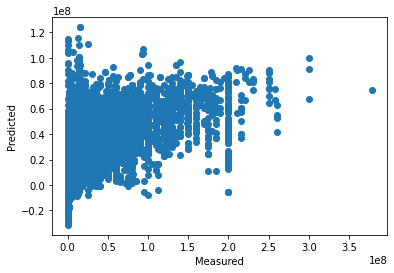

0.2526343991671123
El R2 para Modelo Ridge es de: 0.25263946283560024


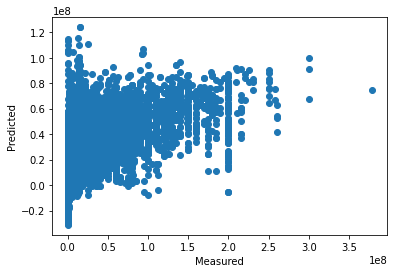

0.25263946283560024


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.857212174007296e+17, tolerance: 2867920477865375.5
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4436748545970176e+17, tolerance: 2824246038618492.0
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8130101309159014e+17, tolerance: 2853071554718062.0
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

El R2 para Modelo Lasso es de: 0.2526344147706844


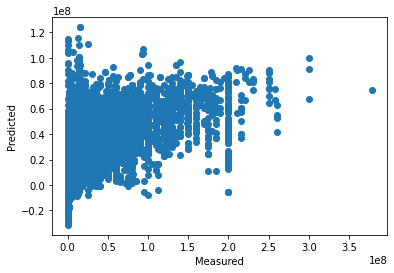

0.2526344147706844
El R2 para AdaBoostRegressor es de: 0.23174884438476506


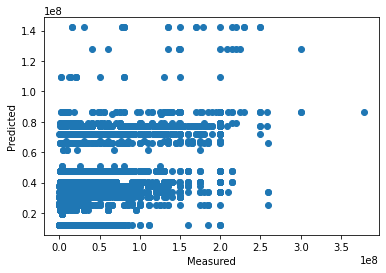

0.23174884438476506
El R2 para GradientBoostingRegressor es de: 0.6752988146342771


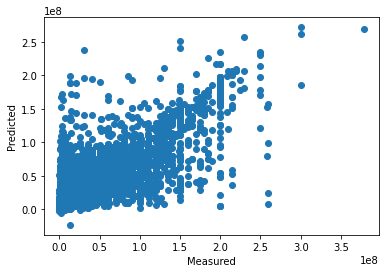

0.6752988146342771
El R2 para RandomForestRegressor es de: 0.681180568124543


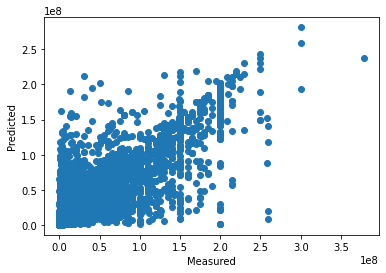

0.681180568124543
El R2 para XGBRegressor es de: 0.7506834336841535


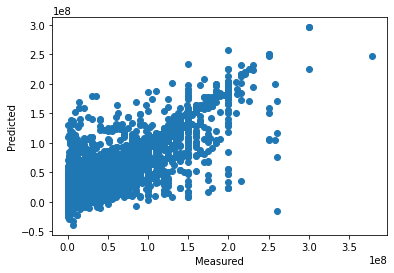

0.7506834336841535
0:	learn: 37293672.1753141	total: 89.1ms	remaining: 357ms
1:	learn: 35014796.1066733	total: 99ms	remaining: 148ms
2:	learn: 33658585.7493252	total: 104ms	remaining: 69.4ms
3:	learn: 32729088.8865331	total: 109ms	remaining: 27.3ms
4:	learn: 32005591.6754125	total: 115ms	remaining: 0us
0:	learn: 36904798.8898915	total: 5.2ms	remaining: 20.8ms
1:	learn: 34675982.6797221	total: 16.2ms	remaining: 24.4ms
2:	learn: 33232885.4651581	total: 22.6ms	remaining: 15.1ms
3:	learn: 32289974.9763966	total: 32.3ms	remaining: 8.09ms
4:	learn: 31628115.9224466	total: 38.5ms	remaining: 0us
0:	learn: 37296695.1126128	total: 6.43ms	remaining: 25.7ms
1:	learn: 35158799.9978156	total: 17ms	remaining: 25.6ms
2:	learn: 33617884.7380708	total: 26ms	remaining: 17.3ms
3:	learn: 33069151.4915291	total: 29.7ms	remaining: 7.42ms
4:	learn: 32433579.4032099	total: 37.4ms	remaining: 0us
0:	learn: 37396846.9196968	total: 6.27ms	remaining: 25.1ms
1:	learn: 35195868.8031775	total: 22ms	remaining: 32.9ms
2

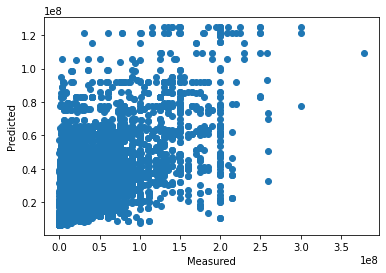

0.3759845624801036


,indices,nombres,hiperparametros,r2,tiempo,modelos
0,0,Regresiones Lineal,{},0.2526343991671123,1.0 segundos,"GridSearchCV(estimator=LinearRegression(), par..."
1,1,Modelo Ridge,{'alpha': 1},0.25263946283560024,1.0 segundos,"GridSearchCV(estimator=Ridge(), param_grid={'a..."
2,2,Modelo Lasso,{'alpha': 1},0.2526344147706844,6.0 segundos,"GridSearchCV(estimator=Lasso(), param_grid={'a..."
3,3,AdaBoostRegressor,"{'n_estimators': 5, 'random_state': 42}",0.23174884438476506,2.0 segundos,"GridSearchCV(estimator=AdaBoostRegressor(),\n ..."
4,4,GradientBoostingRegressor,"{'max_depth': 11, 'n_estimators': 49, 'random_...",0.6752988146342771,13.0 segundos,GridSearchCV(estimator=GradientBoostingRegress...
5,5,RandomForestRegressor,"{'max_depth': 44, 'n_estimators': 44, 'random_...",0.681180568124543,14.0 segundos,GridSearchCV(estimator=RandomForestRegressor()...
6,6,XGBRegressor,"{'alpha': 0, 'iterations': 2, 'learning_rate':...",0.7506834336841535,19.0 segundos,GridSearchCV(estimator=XGBRegressor(base_score...
7,7,CatBoostRegressor,"{'iterations': 5, 'learning_rate': 0.3, 'max_d...",0.3759845624801036,3.0 segundos,GridSearchCV(estimator=<catboost.core.CatBoost...


In [13]:
resultados = test_regresiones_sklearn(X,y)
resultados_r2 = pd.DataFrame({'indices':resultados['indices'],'nombres':resultados['modelos'],'hiperparametros':resultados['hiperparametros'],'r2':resultados['r2'],'tiempo':resultados['tiempo'],'modelos':resultados['modelos_train']})
resultados_r2

# ANALISIS RESULTADOS 

In [14]:
from xgboost.sklearn import XGBRegressor,XGBClassifier
XGBRegressor = XGBRegressor(max_depth=9,iterations=1,alpha=0,learning_rate=0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
modelo = XGBRegressor.fit(X_train,y_train)
predict = modelo.predict(X_test)
print('R2: '+str(r2_score(y_test,predict)))
import lime
import lime.lime_tabular
df_new = X_test
df_array = df_new.sample(1)
modelo.predict(df_array)
import shap  
shap.initjs()

R2: 0.7437076572817423


In [15]:
with open('XGBRegressor_presupuesto.pickle', 'wb') as handle:
    pickle.dump(XGBRegressor, handle, protocol=pickle.HIGHEST_PROTOCOL)

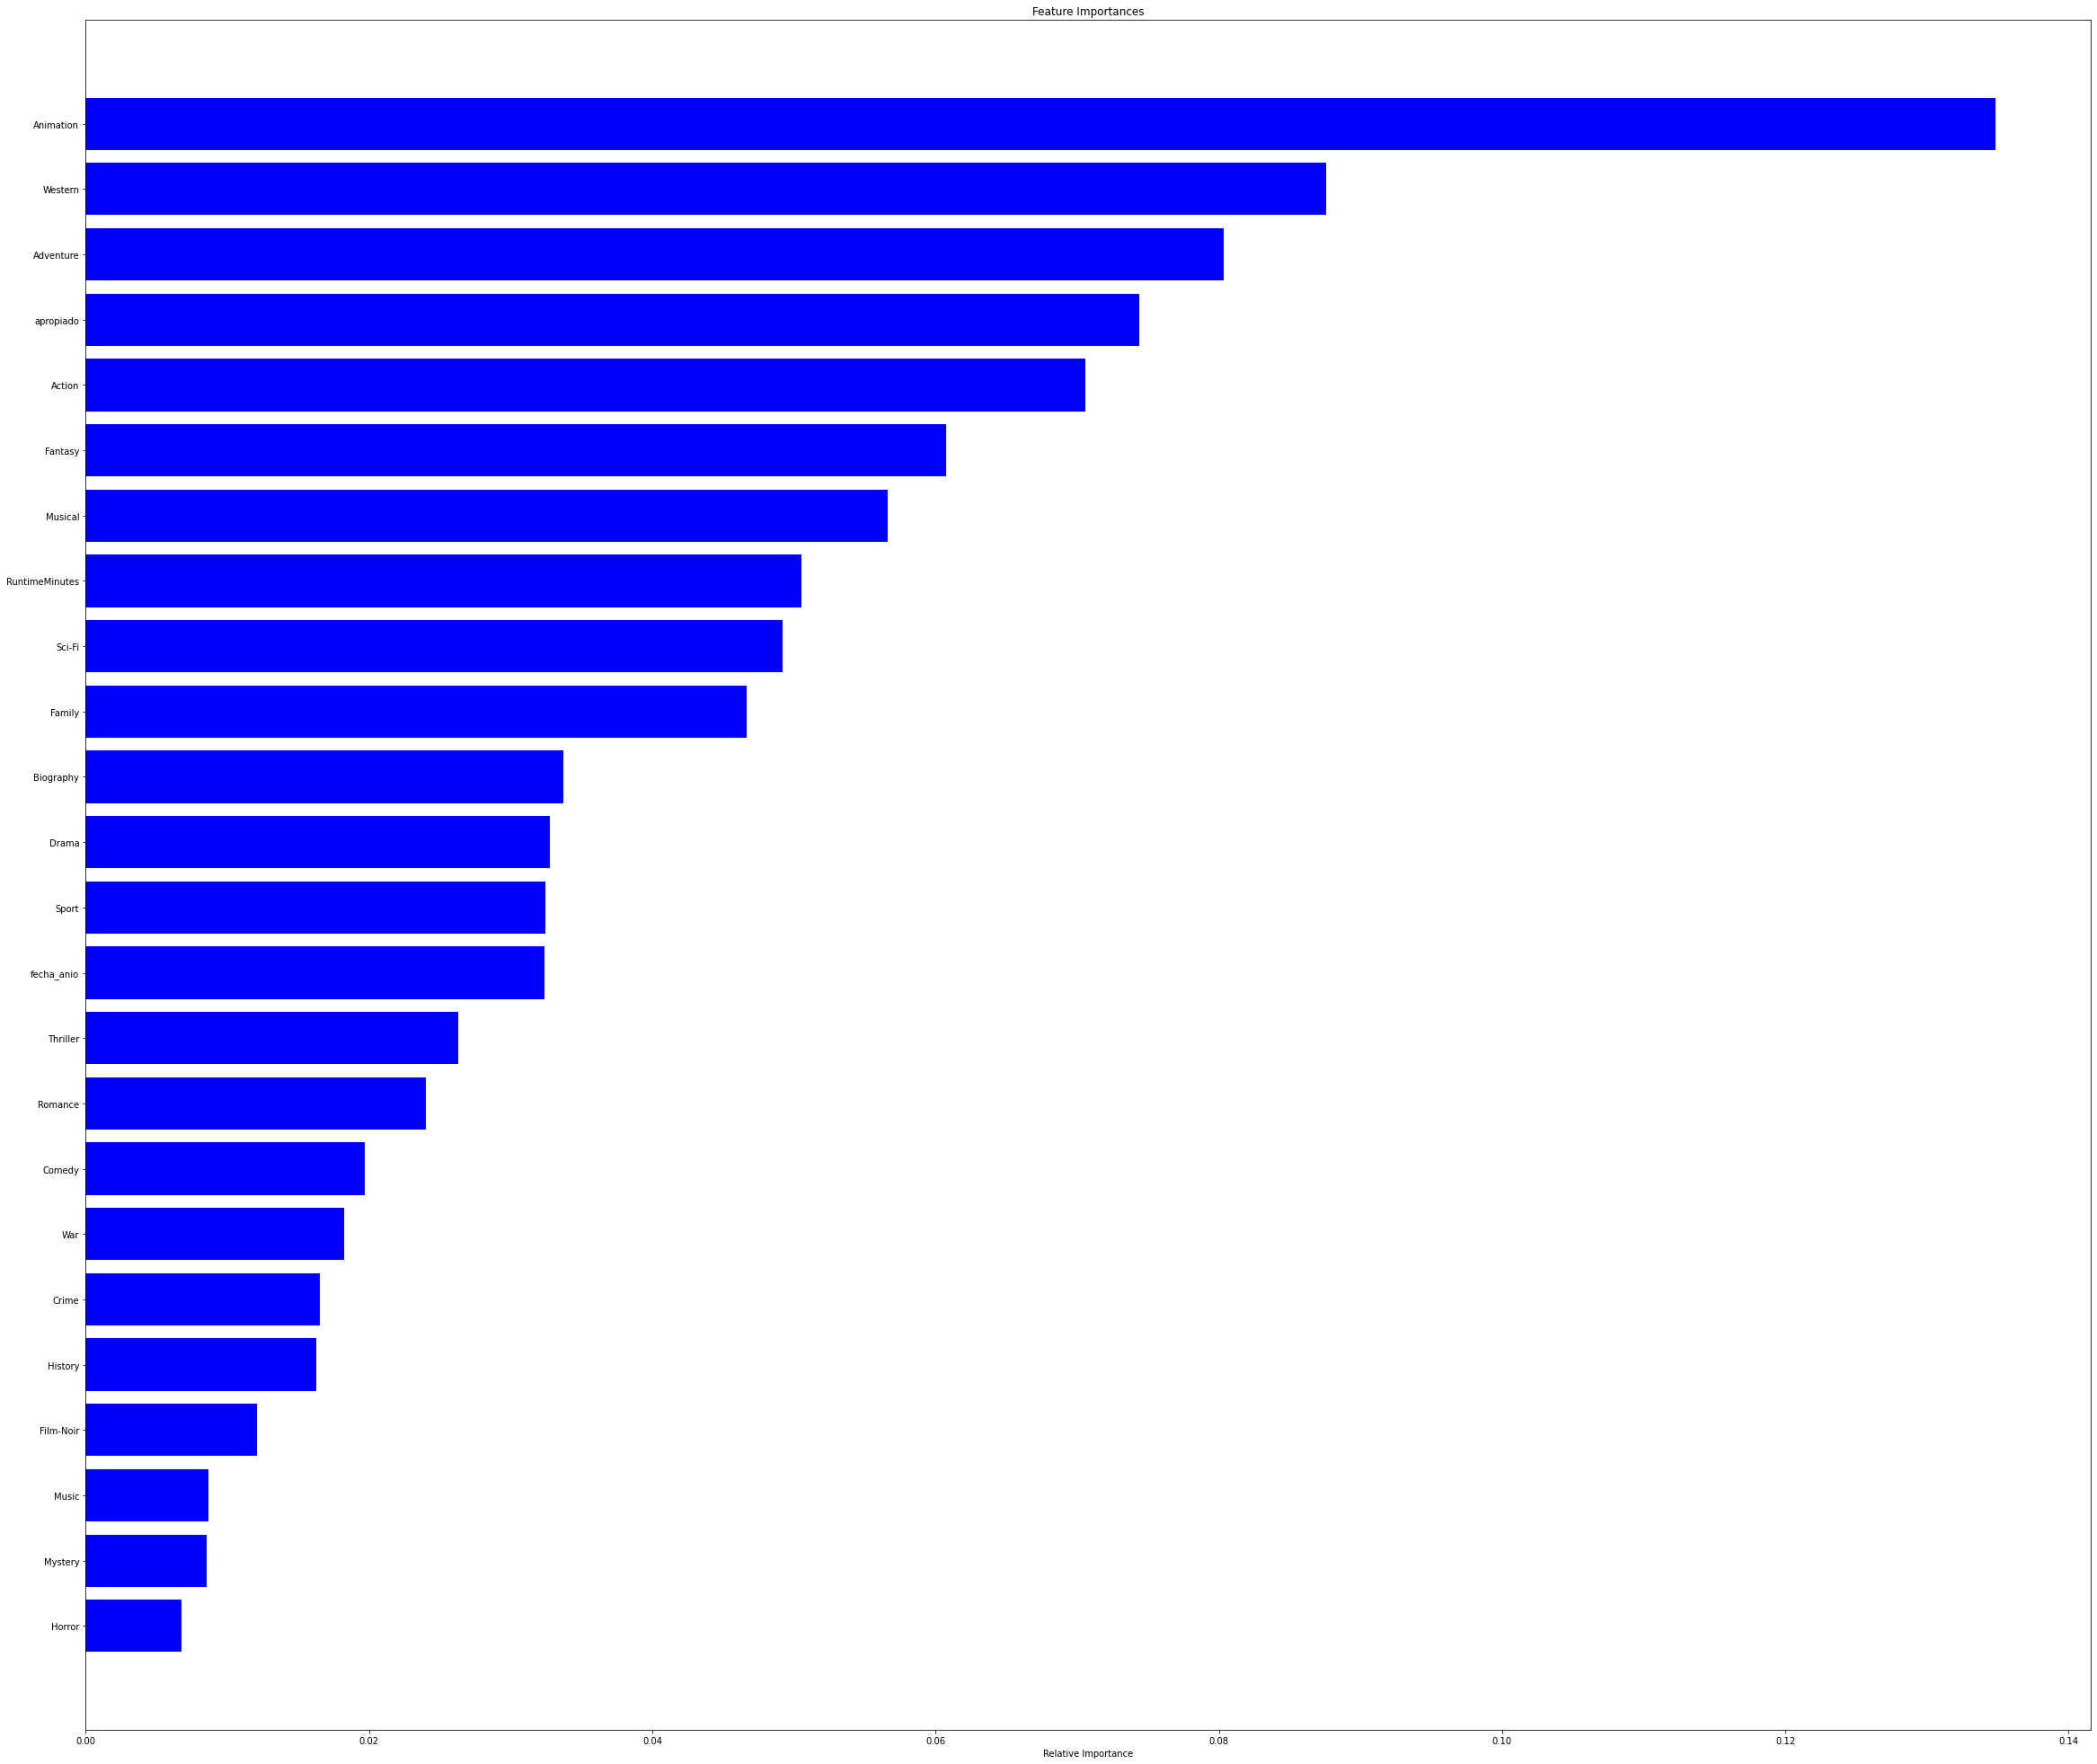

In [16]:
plt.figure(figsize=(40,35))
importances = XGBRegressor.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [17]:
explainer = shap.TreeExplainer(XGBRegressor)
shap_values = explainer.shap_values(df_array)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [18]:
features = X_train.columns
shap.force_plot(explainer.expected_value, shap_values, df_array,feature_names=features)

In [19]:
explainer = shap.TreeExplainer(XGBRegressor)
shap_values = explainer.shap_values(X_test.sample(1000))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


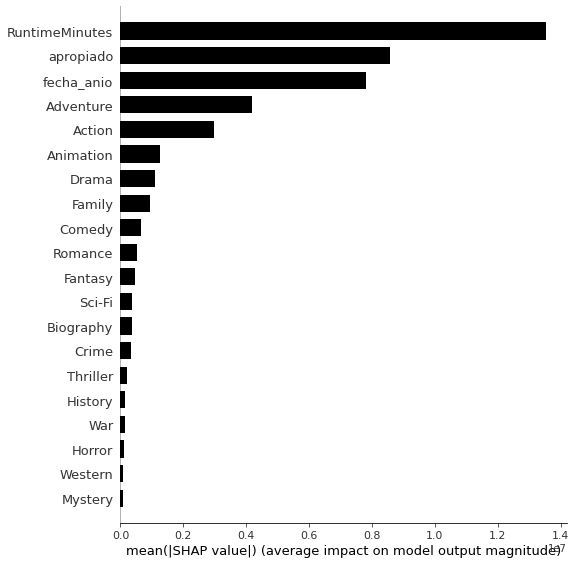

In [20]:
shap.summary_plot(shap_values, X_test.sample(1000), plot_type="bar",color='black')

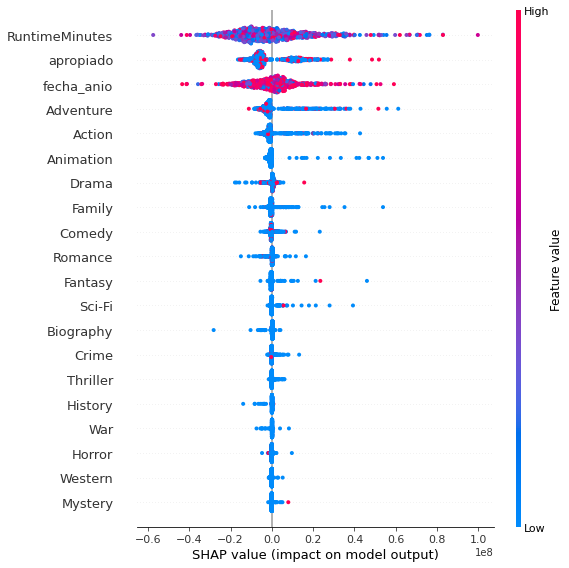

In [21]:
shap.summary_plot(shap_values, X_test.sample(1000))

In [22]:
shap.force_plot(explainer.expected_value, shap_values,X)